## Requirement 1: Stochatic Environment
**Build a stochastic environment including**
- A distribution over the bids of the other agents
- **A function specifying the probability with which an user buys for every price**

**Pricing algorithm: Build a pricing strategy using the continuous set of prices p ∈ [0, 1] and Gaussian Processes.**\
Bidding algorithm: Consider a sequence of second-price auctions. Build two learning algorithms to deal with the bidding problem:
- primal-dual algorithm for truthful auctions
- UCB-like algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from functools import partial

c:\Users\39327\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\39327\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\39327\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Stochastic Pricing Environment

In [2]:
class StochasticPricingEnvironment:
    def __init__(self, model='linear', alpha=None, beta=None):
        self.model = model
        self.alpha = alpha
        self.beta = beta
        np.random.seed(42)


    # given settled price and number customer
    # returns a sample of number of sale and profit
    def round(self, price_t, n_costumer_t):
        # number of sale at time t
        number_sale_t = np.random.binomial(n_costumer_t, StochasticPricingEnvironment.generate_probability(self.model, self.alpha, self.beta, price_t))

        return number_sale_t

    # takes as input the selling price -> [0,1]
    # return as output the probability of selling -> [0,1]
    @staticmethod
    def generate_probability(model, a, b, price):
        def isNotNone(s,d):
            if s is None:
                return d
            else:
                return s
        global purchase_probabilities
        if model == 'linear':
            alpha = isNotNone(a, 1) # Intercept
            beta = isNotNone(b, -1)  # Slope
            purchase_probabilities = alpha + beta * price
            
        elif model == 'logistic':
            alpha = isNotNone(a, 0)
            beta = isNotNone(b, -5)
            purchase_probabilities = 1 / (1 + np.exp(-(alpha + beta * price)))
            
        elif model == 'probit':
            alpha = isNotNone(a, 0)
            beta = isNotNone(b, -5)
            purchase_probabilities = norm.cdf(alpha + beta * price)
            
        elif model == 'KERNEL':
            purchase_probabilities = np.abs(np.sin(2 * np.pi * price) * np.exp(-price * 5) + price * .10) + .1

        return purchase_probabilities


### Pricing Agent : Gaussian Process Agent with RBF kernel and UCB algorithm

In [3]:
# Radial Basis Function Kernel
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [4]:
# From the agent's point of view, action set is [0,1]. 
# If the actual actions are outside this set, perform rescaling outside the class.
class GPUCBAgent:
    def __init__(self, T, minimum_price=0, maximum_price=1, scale=0.1, discretization=None):
        self.T = T
        if(discretization is None):
            # discretization prescribed by theory
            epsilon = T**(-0.33)
            discretization = int(1/epsilon)
        self.minimum_price = minimum_price
        self.maximum_price = maximum_price
        self.arms = np.linspace(minimum_price, maximum_price, discretization)
        self.N_pulls = np.zeros(discretization)
        self.average_bidding_costs = np.zeros(discretization)
        self.gp = RBFGaussianProcess(scale=scale).fit()
        self.a_t = None
        self.action_hist = []
        self.reward_hist = []
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.t = 0
    
    def pull_arm(self, verbose=False):
        # play every arm at least once
        if self.t < len(self.arms):
            self.a_t = self.t
        else:
            self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
            #    averages of GP  +  estimation uncertainty
            buy_probabilities = self.mu_t + self.beta(self.t) * self.sigma_t
            ucbs = buy_probabilities * (self.arms - self.average_bidding_costs)
            self.a_t = np.argmax(ucbs)
            if(verbose):
                print(buy_probabilities)
                print(self.arms - self.average_bidding_costs)
                print(ucbs)
        return self.arms[self.a_t]
    
    def update(self, n_sales_t, n_customers_t, bidding_cost_per_customer_t):
        self.N_pulls[self.a_t] += 1
        self.average_bidding_costs[self.a_t] += (bidding_cost_per_customer_t - self.average_bidding_costs[self.a_t])/self.N_pulls[self.a_t]
        estimated_probability = n_sales_t / n_customers_t
        self.gp = self.gp.fit(self.arms[self.a_t], estimated_probability)
        self.t += 1
        self.action_hist.append(self.arms[self.a_t])
        self.reward_hist.append((self.arms[self.a_t]-self.minimum_price)*n_sales_t - bidding_cost_per_customer_t*n_customers_t)


In [5]:
# UCB1 agent for performance comparison
class UCB1Agent:
    def __init__(self, T, K=None, range=1):
        if K is None:
            # prescribed by theory
            epsilon = T**(-0.33)
            K = int(1/epsilon)
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t, verbose = False):
        if verbose:
            print(f'updating arm {self.a_t} with reward {r_t} average reward : {self.average_rewards[self.a_t]:.2f} -> {(self.average_rewards[self.a_t] + (r_t - self.average_rewards[self.a_t])/(self.N_pulls[self.a_t]+1)):.2f}')
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

### Simulation - Logistic model

In [20]:
def MinMaxScaler(original, min_x, max_x):
    return (original - min_x) / (max_x - min_x)

def MinMaxRescaler(scaled, min_x, max_x):
    return min_x + (max_x - min_x) * scaled

# Environment parameters
T = 500
n_customers = 100
min_price, max_price = 10, 20
cost = 10
# # Linear model example
# model='linear'
# alpha=0.9
# beta=-0.8
# scale=0.1
# Logistic model example
model='logistic'
alpha=0.8
beta=-6
scale=2

# agent parameters
discretization = 20
payed_bid_per_user = 0
scaled_payed_bid_per_user = 0
scaled_min_price = MinMaxScaler(min_price, min_price, max_price)
scaled_max_price = MinMaxScaler(max_price, min_price, max_price)
scaled_cost = MinMaxScaler(cost, min_price, max_price)  # equals to scaled_min_price

# Set up agents and environment
np.random.seed(42)
env = StochasticPricingEnvironment(model, alpha, beta)
agent = GPUCBAgent(T, scaled_min_price, scaled_max_price, discretization=discretization, scale=scale)
ucb_agent = UCB1Agent(T, K=discretization, range=(scaled_max_price-scaled_min_price)/2)
ucb_agent_rewards = []

# Run simulation
for t in range(T):
    # payed_bid_per_user = t % 3
    # scaled_payed_bid_per_user = payed_bid_per_user/(max_price-min_price)

    # UCB1 agent
    pi_t = ucb_agent.pull_arm() ## the agent returns the index of arm (price)!!
    p_t = prices[pi_t] # I get the actual price
    number_sale_t = env.round(p_t, n_customers)
    r_t = (p_t - scaled_cost)*number_sale_t
    ucb_agent.update(r_t)
    ucb_agent_rewards.append(r_t)

    # GPUCB agent
    p_t = agent.pull_arm()
    number_sale_t = env.round(p_t, n_customers)
    total_profit_t = number_sale_t * (p_t - scaled_cost) - n_customers*scaled_payed_bid_per_user
    # print(f'round {t} : p_t={p_t}, number_sale_t={number_sale_t}, total_profit_t={total_profit_t}, bid={payed_bid_per_user}')
    agent.update(number_sale_t, n_customers, scaled_payed_bid_per_user )

# Compute the clairvoyant and Cumulative regret
prices = np.linspace(scaled_min_price, scaled_max_price, discretization)
conversion_probabilities = StochasticPricingEnvironment.generate_probability(model, alpha, beta, prices)
profit_curve = (prices - scaled_cost)*n_customers*conversion_probabilities - np.repeat(n_customers*scaled_payed_bid_per_user, discretization)
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

agent_rewards = np.array(agent.reward_hist)
cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
ucb_agent_rewards = np.array(ucb_agent_rewards)
ucb_cumulative_regret = np.cumsum(expected_clairvoyant_rewards-ucb_agent_rewards)

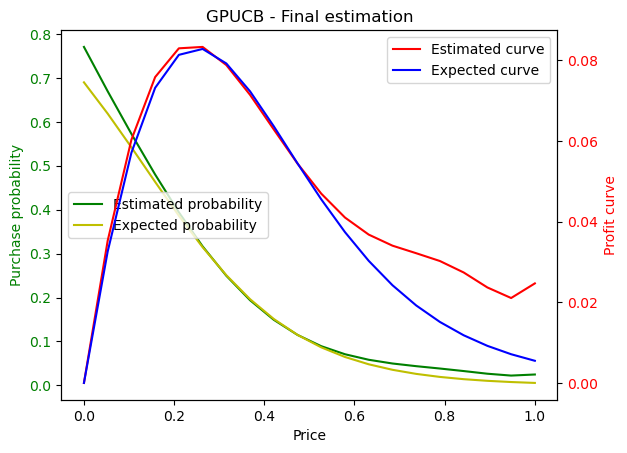

In [21]:
estimated_purchase_probability = (agent.mu_t + agent.beta(agent.t) * agent.sigma_t)
ucbs = estimated_purchase_probability * (agent.arms - agent.average_bidding_costs)
# print(f'purchase probability = {estimated_purchase_probability}')
# print(np.argmax(ucbs))
# print(ucbs[np.argmax(ucbs)])
# print(MinMaxRescaler(agent.arms[np.argmax(ucbs)], min_price,max_price))

fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, conversion_probabilities*prices, 'b-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='upper right')

plt.title('GPUCB - Final estimation')
plt.show()

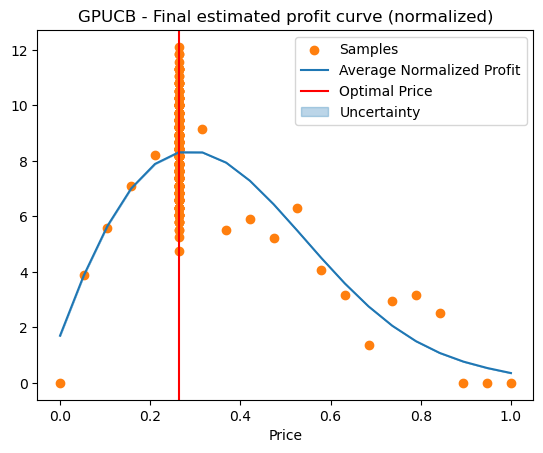

In [22]:
price_hist = agent.action_hist
profits = agent.reward_hist

gp = RBFGaussianProcess(scale=2)
gp.fit(price_hist, profits)
mu, sigma = gp.predict(prices)
plt.scatter(price_hist, profits, label='Samples', color='C1')
plt.plot(prices, mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(prices, mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

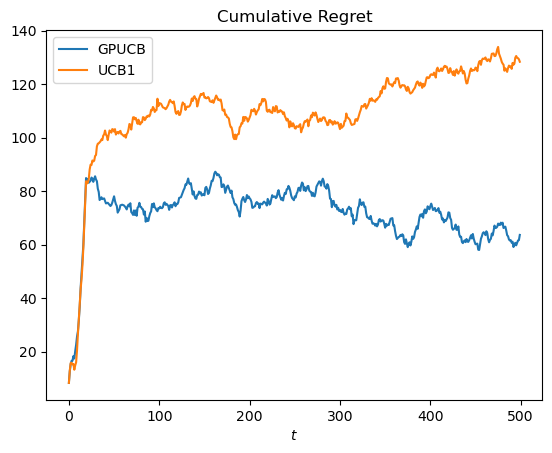

In [23]:
plt.figure()
plt.plot(cumulative_regret, label="GPUCB")
plt.plot(ucb_cumulative_regret, label="UCB1")
plt.legend()
plt.title('Cumulative Regret')
plt.xlabel('$t$')
plt.show();

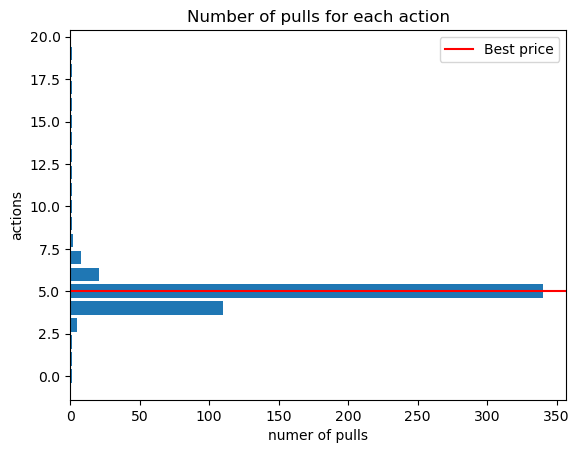

In [24]:
plt.figure()
plt.barh(np.arange(discretization), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

### Simulation - Linear model

In [25]:
def MinMaxScaler(original, min_x, max_x):
    return (original - min_x) / (max_x - min_x)

def MinMaxRescaler(scaled, min_x, max_x):
    return min_x + (max_x - min_x) * scaled

# Environment parameters
T = 500
n_customers = 100
min_price, max_price = 10, 20
cost = 10
# Linear model example
model='linear'
alpha=0.9
beta=-0.8
scale=0.1
# # Logistic model example
# model='logistic'
# alpha=0.8
# beta=-6
# scale=2

# agent parameters
discretization = 20
payed_bid_per_user = 0
scaled_payed_bid_per_user = 0
scaled_min_price = MinMaxScaler(min_price, min_price, max_price)
scaled_max_price = MinMaxScaler(max_price, min_price, max_price)
scaled_cost = MinMaxScaler(cost, min_price, max_price)  # equals to scaled_min_price


np.random.seed(42)
agent = GPUCBAgent(T, scaled_min_price, scaled_max_price, discretization=discretization, scale=scale)
ucb_agent = UCB1Agent(T, K=discretization, range=(scaled_max_price-scaled_min_price)/2)
env = StochasticPricingEnvironment(model, alpha, beta)

# let's compute the clairvoyant
prices = np.linspace(scaled_min_price, scaled_max_price, discretization)
# conversion_probability = partial(StochasticPricingEnvironment.generate_probability, model, alpha, beta)
conversion_probabilities = StochasticPricingEnvironment.generate_probability(model, alpha, beta, prices)
profit_curve = (prices - scaled_cost)*n_customers*conversion_probabilities - np.repeat(n_customers*scaled_payed_bid_per_user, discretization)
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

ucb_agent_rewards = []
for t in range(T):
    # payed_bid_per_user = t % 3
    # scaled_payed_bid_per_user = payed_bid_per_user/(max_price-min_price)

    # UCB1 agent
    pi_t = ucb_agent.pull_arm() ## the agent returns the index of arm (price)!!
    p_t = prices[pi_t] # I get the actual price
    number_sale_t = env.round(p_t, n_customers)
    r_t = (p_t - scaled_cost)*number_sale_t
    ucb_agent.update(r_t)
    ucb_agent_rewards.append(r_t)

    # GPUCB agent
    p_t = agent.pull_arm()
    number_sale_t = env.round(p_t, n_customers)
    total_profit_t = number_sale_t * (p_t - scaled_cost) - n_customers*scaled_payed_bid_per_user
    # print(f'round {t} : p_t={p_t}, number_sale_t={number_sale_t}, total_profit_t={total_profit_t}, bid={payed_bid_per_user}')
    agent.update(number_sale_t, n_customers, scaled_payed_bid_per_user )

agent_rewards = np.array(agent.reward_hist)
cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
ucb_agent_rewards = np.array(ucb_agent_rewards)
ucb_cumulative_regret = np.cumsum(expected_clairvoyant_rewards-ucb_agent_rewards)

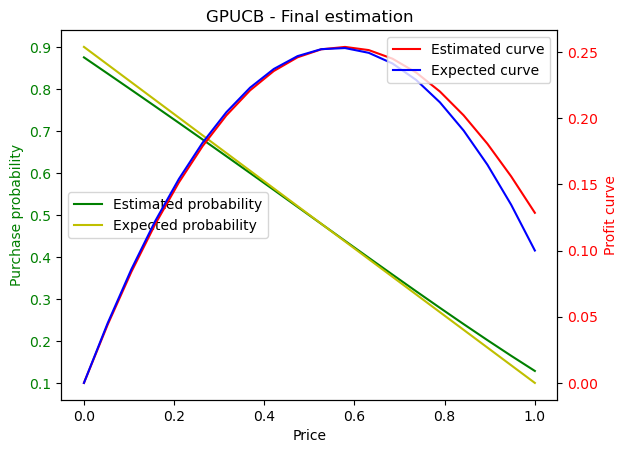

In [26]:
estimated_purchase_probability = (agent.mu_t + agent.beta(agent.t) * agent.sigma_t)
ucbs = estimated_purchase_probability * (agent.arms - agent.average_bidding_costs)
# print(f'purchase probability = {estimated_purchase_probability}')
# print(np.argmax(ucbs))
# print(ucbs[np.argmax(ucbs)])
# print(MinMaxRescaler(agent.arms[np.argmax(ucbs)], min_price,max_price))

fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, conversion_probabilities*prices, 'b-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='upper right')

plt.title('GPUCB - Final estimation')
plt.show()

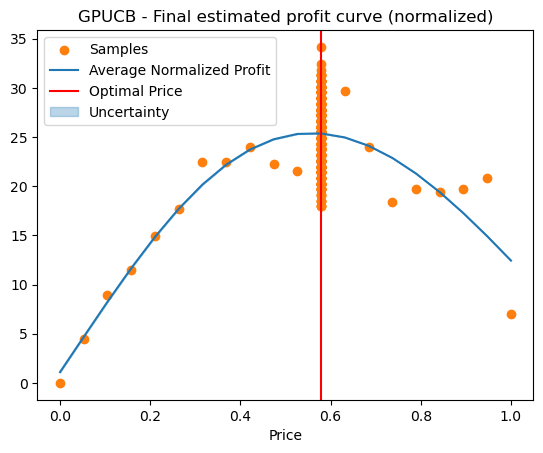

In [27]:
price_hist = agent.action_hist
profits = agent.reward_hist

gp = RBFGaussianProcess(scale=2)
gp.fit(price_hist, profits)
mu, sigma = gp.predict(prices)
plt.scatter(price_hist, profits, label='Samples', color='C1')
plt.plot(prices, mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(prices, mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

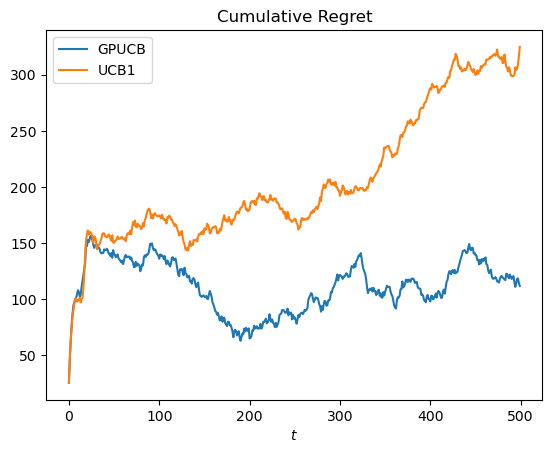

In [28]:
plt.figure()
plt.plot(cumulative_regret, label="GPUCB")
plt.plot(ucb_cumulative_regret, label="UCB1")
plt.legend()
plt.title('Cumulative Regret')
plt.xlabel('$t$')
plt.show();

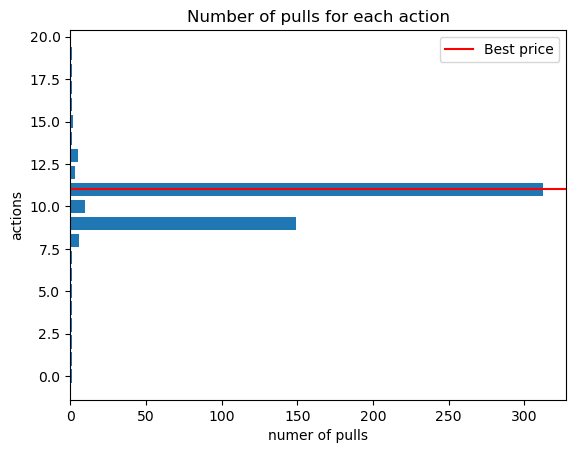

In [29]:
plt.figure()
plt.barh(np.arange(discretization), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();